In [36]:
#library import
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, save_model, Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [37]:
# Dataset Loading Function
def load_dataset(dataset_path, image_size):
    images = []
    labels = []

    for label_folder in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label_folder)
        
        # Check if it's a directory, skip if it's a file like .DS_Store
        if not os.path.isdir(label_path):
            continue

        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)

            # Load and resize image
            img = cv2.imread(image_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                images.append(img)
                labels.append(label_folder)

    return np.array(images), np.array(labels)


In [38]:
# Label Encoding Function
def label_encoding(data_labels):
    general_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']  # Ensure this list is correct
    new_data_labels = []
    for label in data_labels:
        try:
            new_data_labels.append(general_labels.index(label))
        except ValueError:
            print(f"Label '{label}' not found in general_labels")
            raise
    return np.array(new_data_labels)


In [39]:
# Augmented Samples Plotting Function
def plot_augmented_samples(X_train, train_datagen, seed=None):

    def plot_images(images, titles, ncols=6, figsize=(15, 15)):
        fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
        for i, (img, title) in enumerate(zip(images, titles)):
            ax[i].imshow(img)
            ax[i].set_title(title)
            ax[i].axis('off')
        plt.show()

    if seed is not None:
        np.random.seed(seed)

    sample_indices = np.random.choice(len(X_train), 3, replace=False)
    samples = X_train[sample_indices]

    for sample in samples:
        images = [sample]  # Start with the original image
        titles = ['Original']

        generator = train_datagen.flow(sample.reshape((1,) + sample.shape), batch_size=1)

        # Generate 5 augmented images
        for i in range(5):
            augmented_image = next(generator)[0]
            if augmented_image.dtype in ['float32', 'float64']:
                augmented_image = (augmented_image * 255).astype('uint8')
            images.append(augmented_image)
            titles.append(f'Augmented {i+1}')

        plot_images(images, titles)


In [40]:
# Data Generators Creation Function
def make_generators(X_train, X_val, X_test, encoded_y_train, encoded_y_val, encoded_y_test, batch_size, augment=False):
    if augment:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest')
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    # For validation and test data, you typically only rescale
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    if augment:
        plot_augmented_samples(X_train, train_datagen)

    train_generator = train_datagen.flow(X_train, encoded_y_train, batch_size=batch_size, shuffle=True, seed=101)

    val_generator = val_datagen.flow(X_val, encoded_y_val, batch_size=batch_size, shuffle=False)

    test_generator = test_datagen.flow(X_test, encoded_y_test, batch_size=batch_size, shuffle=False)

    return train_generator, val_generator, test_generator


In [41]:
# VGG19 Model Creation Function
def create_vgg19_model(input_shape, dropout_rate, n_hidden):
    # Load VGG19 with pre-trained ImageNet weights, excluding the top layers
    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the convolutional base layers
    vgg19_base.trainable = False

    model = Sequential()
    model.add(vgg19_base)  # Add the VGG19 base
    model.add(Flatten())   # Flatten the output of the VGG19 base

    # Add fully connected layers
    for n in n_hidden:
        model.add(Dense(units=n, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Add output layer
    model.add(Dense(units=4, activation='softmax'))

    print(model.summary())
    return model


In [42]:
def get_model(model_type, params):
    if model_type == 'cnn_model':
        return create_vgg19_model(
            input_shape=params['input_shape'],
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            pool_size=params['pool_size'],
            dropout_rate=params['dropout_rate'],
            n_hidden=params['n_hidden']
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")

In [43]:
# Training Results Visualization Function
def plot_results(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()


In [44]:
# Confusion Matrix Plotting Function
def plot_confusion_matrix(model, test_generator, encoded_y_test):
    # Predict on the test data
    predictions = model.predict(test_generator)
    predicted_classes = [np.argmax(pred) for pred in predictions]

    # Create the confusion matrix
    conf_matrix = confusion_matrix(encoded_y_test, predicted_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Define class labels
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    # Add labels to the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Annotate each cell with the count
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()


In [45]:
# Classification Report Plotting Function
def plot_classification_report(model, test_generator, encoded_y_test):
    # Predict on the test data
    predictions = model.predict(test_generator)
    predicted_classes = [np.argmax(pred) for pred in predictions]

    # Define class labels
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    # Generate the classification report
    report = classification_report(encoded_y_test, predicted_classes, target_names=classes, output_dict=True)

    # Extract precision, recall, and F1-score for each class
    metrics = {label: report[label] for label in classes if label in report}
    precision = [metrics[label]['precision'] for label in classes]
    recall = [metrics[label]['recall'] for label in classes]
    f1_score = [metrics[label]['f1-score'] for label in classes]

    # Create a DataFrame for visualization
    data = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }
    df = pd.DataFrame(data, index=classes)

    # Plot the classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
    plt.title('Classification Report')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()


In [46]:
# Model Evaluation Function
def evaluate_model(model, test_generator):
    # Evaluate the model on the test data
    evaluation = model.evaluate(test_generator)
    
    # Extract test loss and accuracy
    test_loss = evaluation[0]
    test_accuracy = evaluation[1]

    return test_loss, test_accuracy


In [47]:
# Run Experiment Function
def run_experiment(params, X_train, X_val, X_test, encoded_y_train, encoded_y_val, encoded_y_test):
    # Get model based on the specified type and parameters
    model = get_model(params['model_type'], params)

    # Compile the model with Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Create data generators for training, validation, and testing
    train_gen, val_gen, test_gen = make_generators(
        X_train, X_val, X_test,
        encoded_y_train, encoded_y_val, encoded_y_test,
        batch_size=params['batch_size'],
        augment=params['augment']
    )

    # Train the model
    history = model.fit(train_gen, validation_data=val_gen, epochs=params['epochs'], verbose=1)
    
    # Plot training results (loss and accuracy)
    plot_results(history)

    # Plot confusion matrix
    plot_confusion_matrix(model, test_gen, encoded_y_test)

    # Plot classification report
    plot_classification_report(model, test_gen, encoded_y_test)

    # Evaluate model on the test set
    loss, accuracy = evaluate_model(model=model, test_generator=test_gen)

    # Save the trained model to an .h5 file
    model_file_name = f"model_{params['model_type']}_epochs_{params['epochs']}_batch_{params['batch_size']}.h5"
    model.save(model_file_name)
    print(f"Model saved as {model_file_name}")

    # Return a dictionary with relevant results
    result = {
        'Model': model,
        'Model Type': params['model_type'],
        'With Augmentation': 'Yes' if params['augment'] else 'No',
        'Input Shape': params['input_shape'],
        'Epochs': params['epochs'],
        'Batch Size': params['batch_size'],
        'Test Loss': loss,
        'Test Accuracy': accuracy,
        'Model File': model_file_name
    }

    return result


In [48]:
experiments = [
    {
        'model_type': 'basic_cnn',
        'dropout_rate': 0.5,
        'filters': [32, 64, 128, 256, 512],
        'input_shape': (224, 224, 3),
        'epochs': 60,
        'batch_size': 32,
        'kernel_size': (3, 3),
        'pool_size': (2, 2),
        'n_hidden': [512],
        'augment': True,
        'image_size': (224, 224)
    }
]


In [49]:
brain_dataset_training_path = '/Users/shaunak/brain/archive/Training'
brain_dataset_testing_path = '/Users/shaunak/brain/archive/Testing'
vgg_experiments = []

Running experiment with parameters: {'model_type': 'basic_cnn', 'dropout_rate': 0.5, 'filters': [32, 64, 128, 256, 512], 'input_shape': (224, 224, 3), 'epochs': 60, 'batch_size': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'n_hidden': [512], 'augment': True, 'image_size': (224, 224)}
Train images shape is : (2296, 224, 224, 3)
Train labels shape is : (2296,)
Validation images shape is : (574, 224, 224, 3)
Validation labels shape is : (574,)
Test images shape is : (394, 224, 224, 3)
Test labels shape is : (394,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                               

None


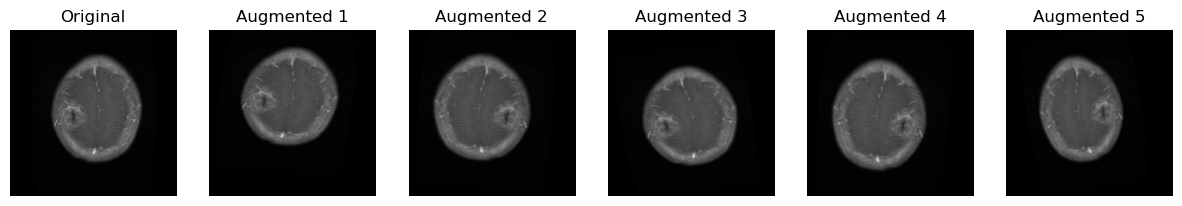

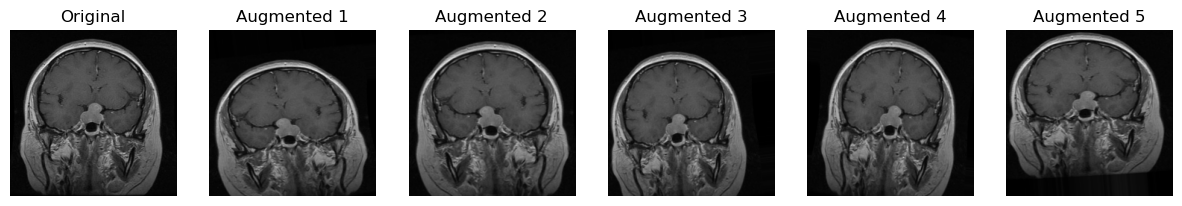

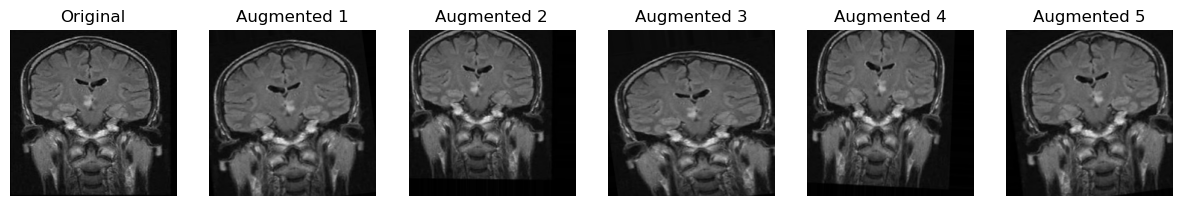

Epoch 1/60
72/72 [==============================] - 156s 2s/step - loss: 1.2754 - accuracy: 0.3863 - val_loss: 1.1233 - val_accuracy: 0.4443
Epoch 2/60
72/72 [==============================] - 154s 2s/step - loss: 1.0840 - accuracy: 0.5065 - val_loss: 0.9779 - val_accuracy: 0.5592
Epoch 3/60
72/72 [==============================] - 156s 2s/step - loss: 0.9142 - accuracy: 0.5897 - val_loss: 0.7572 - val_accuracy: 0.6707
Epoch 4/60
72/72 [==============================] - 157s 2s/step - loss: 0.7999 - accuracy: 0.6468 - val_loss: 0.6800 - val_accuracy: 0.7230
Epoch 5/60
72/72 [==============================] - 157s 2s/step - loss: 0.7584 - accuracy: 0.6559 - val_loss: 0.6772 - val_accuracy: 0.6864
Epoch 6/60
72/72 [==============================] - 158s 2s/step - loss: 0.7175 - accuracy: 0.6855 - val_loss: 0.5835 - val_accuracy: 0.7909
Epoch 7/60
72/72 [==============================] - 157s 2s/step - loss: 0.6678 - accuracy: 0.7060 - val_loss: 0.6813 - val_accuracy: 0.6916
Epoch 8/60
72

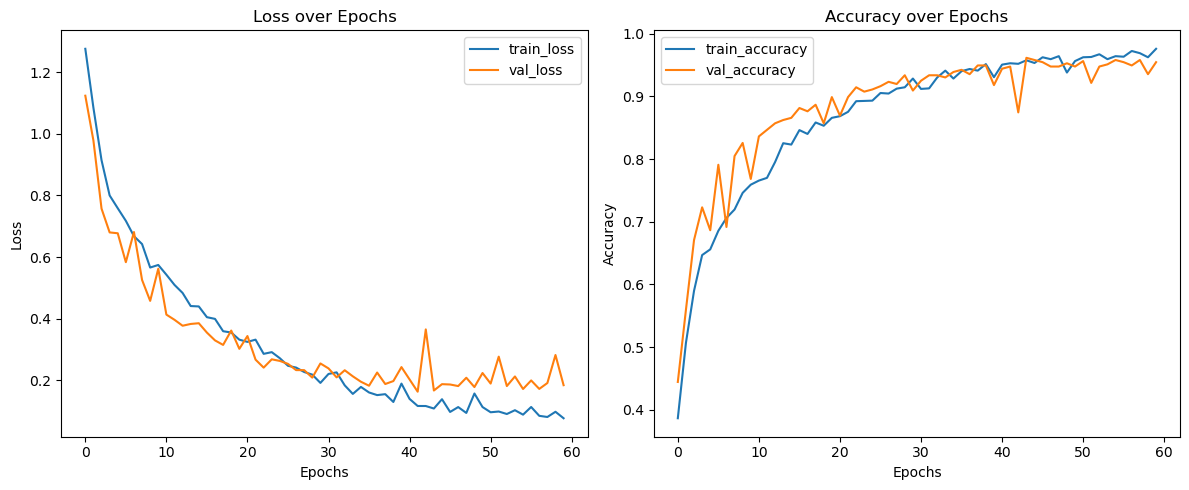

13/13 [==============================] - 8s 619ms/step


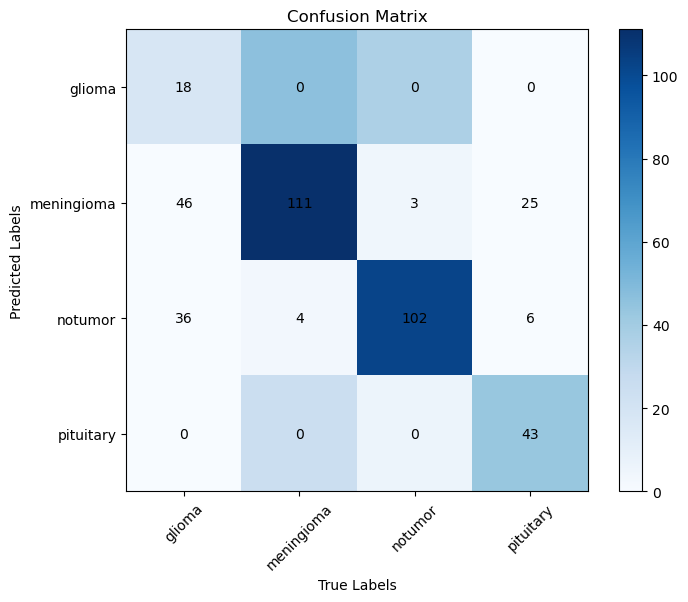

13/13 [==============================] - 8s 626ms/step


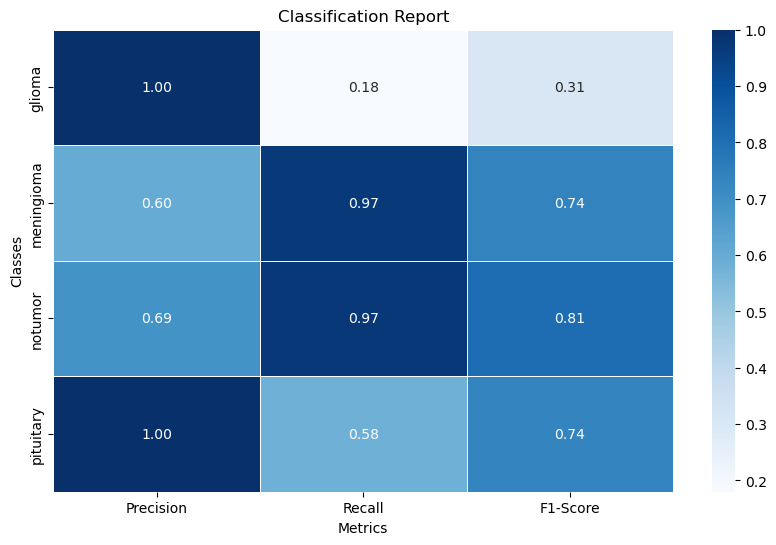

13/13 [==============================] - 8s 626ms/step - loss: 3.9869 - accuracy: 0.6954


/Users/shaunak/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as model_basic_cnn_epochs_60_batch_32.h5


In [50]:
for params in experiments:
    print(f"Running experiment with parameters: {params}")

    X_train, y_train = load_dataset(brain_dataset_training_path, params['image_size'])
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
    X_test, y_test = load_dataset(brain_dataset_testing_path, params['image_size'])

    encoded_y_train = label_encoding(y_train)
    encoded_y_val = label_encoding(y_val)
    encoded_y_test = label_encoding(y_test)

    print(f'Train images shape is : {X_train.shape}')
    print(f'Train labels shape is : {encoded_y_train.shape}')

    print(f'Validation images shape is : {X_val.shape}')
    print(f'Validation labels shape is : {encoded_y_val.shape}')

    print(f'Test images shape is : {X_test.shape}')
    print(f'Test labels shape is : {encoded_y_test.shape}')

    result = run_experiment(params, X_train, X_val, X_test, encoded_y_train, encoded_y_val, encoded_y_test)

    vgg_experiments.append(result)